http://ipyparallel.readthedocs.io/en/latest/dag_dependencies.html

In [1]:
import networkx as nx
import numpy as np
import time
import ipyparallel as ipp
from matplotlib.dates import date2num
from matplotlib.cm import gist_rainbow
from matplotlib import pyplot as plt

np.random.seed(0)

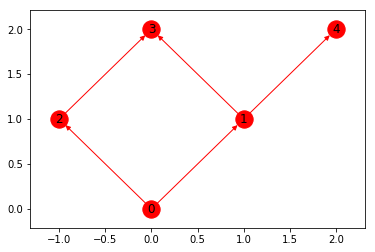

In [2]:
G = nx.DiGraph()

# add 5 nodes, labeled 0-4:
map(G.add_node, range(5))
# 1,2 depend on 0:
G.add_edge(0,1)
G.add_edge(0,2)
# 3 depends on 1,2
G.add_edge(1,3)
G.add_edge(2,3)
# 4 depends on 1
G.add_edge(1,4)

# now draw the graph:
pos = { 0 : (0,0), 1 : (1,1), 2 : (-1,1),
        3 : (0,2), 4 : (2,2)}
nx.draw_networkx(G, pos, edge_color='r')
plt.draw()

In [3]:
# A topological sort is a nonunique permutation of the nodes such that an edge 
# from u to v implies that u appears before v in the topological sort order.
list(nx.topological_sort(G))

[0, 2, 1, 4, 3]

In [4]:
def random_dag(nodes, edges):
    """Generate a random Directed Acyclic Graph (DAG) with a given number of nodes and edges."""
    G = nx.DiGraph()
    for i in range(nodes):
        G.add_node(i)
    while edges > 0:
        a = np.random.randint(0,nodes-1)
        b = a
        while b == a:
            b = np.random.randint(0,nodes-1)
        G.add_edge(a,b)
        if nx.is_directed_acyclic_graph(G):
            edges -= 1
        else:
            # we closed a loop!
            G.remove_edge(a,b)
    return G

In [5]:
G = random_dag(16, 64)

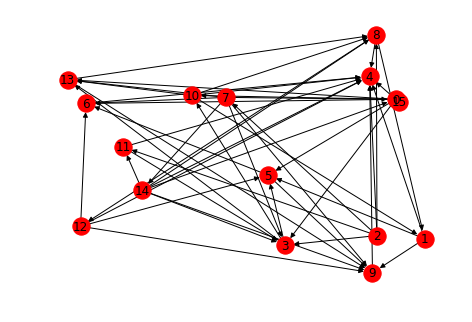

In [14]:
nx.draw_random(G, with_labels = True)
plt.draw()

In [7]:
def randomwait():
    return lambda : time.sleep(4 * np.random.rand())


jobs = {}
for node in G:
    # jobs[node] = lambda : time.sleep(1 + np.random.rand())
    jobs[node] = randomwait

https://github.com/jupyter/notebook/issues/3526  
pip install --upgrade --ignore-installed notebook  

In [8]:
rc = ipp.Client()
view = rc.load_balanced_view()

results = {}

for node in nx.topological_sort(G):
    # get list of AsyncResult objects from nodes
    # leading into this one as dependencies
    deps = [ results[n] for n in G.predecessors(node) ]
    # submit and store AsyncResult object
    with view.temp_flags(after=deps, block=False):
        results[node] = view.apply(jobs[node])

In [9]:
# Now that we have submitted all the jobs, we can wait for the results
view.wait(results.values())

True

In [10]:
def validate_tree(G, results):
    """Validate that jobs executed after their dependencies."""
    for node in G:
        started = results[node].metadata.started
        for parent in G.predecessors(node):
            finished = results[parent].metadata.completed
            assert started > finished, "%s should have happened after %s"%(node, parent)

In [11]:
pos = {}
colors = {}

for node in G:
    md = results[node].metadata
    # print(md)
    start = date2num(md.started)
    runtime = date2num(md.completed) - start
    pos[node] = (np.modf(start)[0] * 10000000, runtime * 1000000000)
    colors[node] = md.engine_id


In [12]:
pos

{0: (5186667.9126396775, 6.984919309616089),
 1: (5186671.320116147, 7.334165275096893),
 2: (5186665.243236348, 7.683411240577698),
 3: (5186668.849783018, 8.381903171539307),
 4: (5186673.635616899, 7.566995918750763),
 5: (5186672.155978158, 7.566995918750763),
 6: (5186672.810232267, 7.799826562404633),
 7: (5186666.075605899, 9.42964106798172),
 8: (5186670.676339418, 7.101334631443024),
 9: (5186672.878917307, 8.731149137020111),
 10: (5186669.4644559175, 6.752088665962219),
 11: (5186668.219976127, 7.101334631443024),
 12: (5186671.398114413, 7.916241884231567),
 13: (5186670.0779646635, 7.799826562404633),
 14: (5186666.960362345, 15.25040715932846),
 15: (5186664.413195103, 9.19681042432785)}

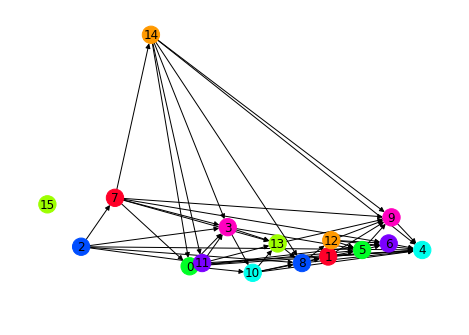

In [15]:
nx.draw(G, pos, with_labels = True, node_list=colors.keys(), node_color=list(colors.values()), cmap=gist_rainbow)
plt.draw()